In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import tensorflow as tf
import os
from keras import objectives
import numpy as np 
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input,Model,layers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import *

Using TensorFlow backend.


注意图像的像素值为0\~255的int值或者0\~1的float值。产生一个tensor时，默认类型是推断出来的。不同类型的tensor不能执行运算。比如下面的img读入时推断出是Int类型,因此`img/255.0`会报错。但是`img/255`的结果可以自动推断出是float类型，为确保潜在的类型匹配错误，使用dtype显示指定.

In [2]:
img_raw = tf.io.read_file(os.path.join("data/membrane/train/image","0.png"))
mask_raw =  tf.io.read_file(os.path.join("data/membrane/train/label/","0.png"))

In [3]:
img = tf.image.decode_png(img_raw)
mask = tf.image.decode_png(mask_raw)

(-0.5, 511.5, 511.5, -0.5)

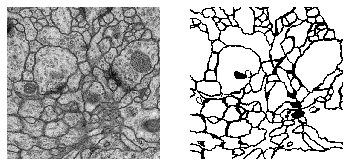

In [4]:
plt.subplot(1, 2, 1)
plt.imshow(img[:,:,0],cmap="gray")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(mask[:,:,0],cmap="gray")
plt.axis("off")

In [5]:
# 将图片进行二值化处理
def adjustData(img,mask):
    img = img / 255
    mask = mask /255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return (img,mask)

In [6]:
def trainGenerator(batch_size,train_path,aug_dict,
                   image_save_prefix  = "image",mask_save_prefix  = "mask",
                   save_to_dir = None,target_size = (256,256),seed = 1):
    '''
    可以不断地同时产生image和mask
    使用相同的seed确保到image_datagen和mask_datagen对图片的扩充是对应的
    '''
    # 两个生成器，aug_dict指定了如何扩充
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = ["image"],
        class_mode = None,
        color_mode = "grayscale",
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)
    mask_generator = mask_datagen.flow_from_directory(
         train_path,
        classes = ["label"],
        class_mode = None,
        color_mode = "grayscale",
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)
    train_generator = zip(image_generator, mask_generator)
    # img.shape == (batch_size,target_szie[0],arget_szie[1],1)
    for (img,mask) in train_generator:
        img,mask = adjustData(img,mask)
        yield (img,mask)


In [7]:
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
myGene = trainGenerator(1,'data/membrane/train',data_gen_args,save_to_dir = None)



In [8]:
def make_generator_model(pretrained_weights = None,input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPool2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPool2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPool2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPool2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = -1)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = -1)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = -1)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = -1)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    return model
    

In [9]:


def make_discriminator_model():
    k=3 # kernel size
    s=2 # stride
    n_filters = 64
    padding='same'#'valid
    name ="d"
    inp = tf.keras.layers.Input(shape=[256, 256, 1], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 1], name='target_image')
    inp1 = Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal')(inp)
    tar1 = Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal')(tar)
    
    
    x = tf.keras.layers.concatenate([inp1, tar1]) 
    conv1 = Conv2D(n_filters, kernel_size=(k, k), strides=(s,s), padding=padding)(x)
    conv1 = BatchNormalization(scale=False, axis=3)(conv1)
    conv1 = Activation('relu')(conv1)    
    conv1 = Conv2D(n_filters, kernel_size=(k, k), padding=padding)(conv1) 
    conv1 = BatchNormalization(scale=False, axis=3)(conv1)
    conv1 = Activation('relu')(conv1)    
    pool1 = MaxPooling2D(pool_size=(s, s))(conv1)
    
    conv2 = Conv2D(2*n_filters, kernel_size=(k, k), strides=(s,s), padding=padding)(pool1) 
    conv2 = BatchNormalization(scale=False, axis=3)(conv2)
    conv2 = Activation('relu')(conv2)    
    conv2 = Conv2D(2*n_filters, kernel_size=(k, k), padding=padding)(conv2) 
    conv2 = BatchNormalization(scale=False, axis=3)(conv2)
    conv2 = Activation('relu')(conv2)    
    pool2 = MaxPooling2D(pool_size=(s, s))(conv2)
    
    conv3 = Conv2D(4*n_filters, kernel_size=(k, k), padding=padding)(pool2) 
    conv3 = BatchNormalization(scale=False, axis=3)(conv3)
    conv3 = Activation('relu')(conv3)    
    conv3 = Conv2D(4*n_filters, kernel_size=(k, k), padding=padding)(conv3) 
    conv3 = BatchNormalization(scale=False, axis=3)(conv3)
    conv3 = Activation('relu')(conv3)    
    pool3 = MaxPooling2D(pool_size=(s, s))(conv3)
    
    conv4 = Conv2D(8*n_filters, kernel_size=(k, k), padding=padding)(pool3) 
    conv4 = BatchNormalization(scale=False, axis=3)(conv4)
    conv4 = Activation('relu')(conv4)    
    conv4 = Conv2D(8*n_filters, kernel_size=(k, k), padding=padding)(conv4) 
    conv4 = BatchNormalization(scale=False, axis=3)(conv4)
    conv4 = Activation('relu')(conv4)    
    pool4 = MaxPooling2D(pool_size=(s, s))(conv4)
    
    conv5 = Conv2D(16*n_filters, kernel_size=(k, k), padding=padding)(pool4) 
    conv5 = BatchNormalization(scale=False, axis=3)(conv5)
    conv5 = Activation('relu')(conv5)    
    conv5 = Conv2D(16*n_filters, kernel_size=(k, k), padding=padding)(conv5) 
    conv5 = BatchNormalization(scale=False, axis=3)(conv5)
    conv5 = Activation('relu')(conv5)
    
    gap=GlobalAveragePooling2D()(conv5)
    outputs=Dense(1, activation='sigmoid')(gap)
    
    d = Model([inp,tar], outputs, name=name)


    d.compile(optimizer=Adam(lr=0.0001), loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
    return d

In [10]:
generator = make_generator_model()
discriminator = make_discriminator_model()

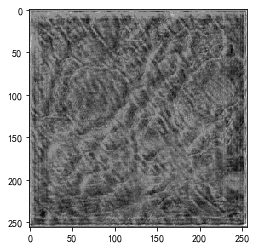

In [11]:
img_test_raw = tf.io.read_file(os.path.join("data/membrane/train/image/","0.png"))
img_test = tf.image.decode_png(img_test_raw)
img_test = tf.image.resize(img_test, (256,256))
img_test = img_test /  255
img_test = tf.reshape(img_test,(1,256,256,1))

generated_image = generator(img_test, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

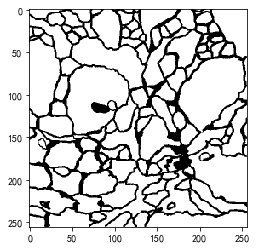

In [12]:
mask_test_raw = tf.io.read_file(os.path.join("data/membrane/train/label/","0.png"))
mask_test = tf.image.decode_png(mask_test_raw)
mask_test = tf.image.resize(mask_test, (256,256))
mask_test = mask_test /  255
mask_test = tf.reshape(mask_test,(1,256,256,1))


plt.imshow(mask_test[0, :, :, 0], cmap='gray')

In [13]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4,)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4)

In [14]:
# 该方法返回计算交叉熵损失的辅助函数
loss_object = tf.keras.losses.BinaryCrossentropy()


In [15]:
LAMBDA = 0.01
def generator_loss(disc_generated_output, gen_output, target):
    dis_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    gan_loss = loss_object(target, gen_output)
    total_loss = gan_loss + (LAMBDA*dis_loss)
    
    return total_loss

In [16]:
@tf.function
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # 生成器产生分割结果
        gen_output = generator(input_image, training=True)
        # 判别器对真实label的输出
        disc_real_output = discriminator([input_image, target], training=True)
        # 判别器对生成label的输出
        disc_generated_output = discriminator([input_image, gen_output], training=True)
        
        # 判别器总损失
        real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
        generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
        disc_total_loss = real_loss + generated_loss
        
        
        gen_total_loss = generator_loss(disc_generated_output, gen_output, target)
    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_total_loss,
                                               discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))


In [17]:
def fit(epochs, myGene,steps):
  for epoch in range(epochs):
    step = 0
    for inp_target_tuple in myGene:
        step += 1
        input_image = inp_target_tuple[0]
        target = inp_target_tuple[1]
        train_step(input_image, target ,epoch)
        
        if(step > steps):
            print("训练完成")
            break
        if(step % 100 == 0):
            print("已经完成：",step)

In [18]:
fit(1, myGene , 2000)

Found 30 images belonging to 1 classes.
Found 30 images belonging to 1 classes.


W1204 10:09:23.102205 140312130967360 deprecation.py:323] From /home/hadoop/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:182: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


已经完成： 100
已经完成： 200
已经完成： 300
已经完成： 400
已经完成： 500
已经完成： 600
已经完成： 700
已经完成： 800
已经完成： 900
已经完成： 1000
已经完成： 1100
已经完成： 1200
已经完成： 1300
已经完成： 1400
已经完成： 1500
已经完成： 1600
已经完成： 1700
已经完成： 1800
已经完成： 1900
已经完成： 2000
训练完成


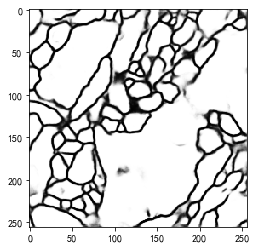

In [32]:
img_test_raw = tf.io.read_file(os.path.join("data/membrane/test/","0.png"))
img_test = tf.image.decode_png(img_test_raw)
img_test = tf.image.resize(img_test, (256,256))
img_test = img_test /  255
img_test = tf.reshape(img_test,(1,256,256,1))

generated_image = generator(img_test, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [33]:
plt.imsave("result-test-0.png",generated_image[0, :, :, 0],cmap="gray")

In [34]:
generator.save("Unet-gen-of-GAN.h5")

In [35]:
discriminator.save("dis-of-GAN.h5")